In [109]:
import os
import time

import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.diffusion_wrapper import LatentDiffusionWrapper
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.quad_logging import iprint as print
from quadrotor_diffusion.utils.plotting import plot_states,  plot_ref_obs_states, add_gates_to_course, add_trajectory_to_course, course_base_plot
from quadrotor_diffusion.utils.simulator import play_trajectory, create_perspective_rendering
from quadrotor_diffusion.utils.file import get_checkpoint_file, get_sample_folder, load_course_trajectory
from quadrotor_diffusion.utils.nn.post_process import fit_to_recon
from quadrotor_diffusion.utils.plotting import plot_states
from quadrotor_diffusion.utils.trajectory import derive_trajectory
from quadrotor_diffusion.planner import plan, cudnn_benchmark, SamplerType, ScoringMethod

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
COURSE = "../data/courses/eval/212"
# COURSE = "../data/courses/triangle/12"
EXPERIMENT = 188

model: LatentDiffusionWrapper = None
ema: LatentDiffusionWrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", EXPERIMENT)
diff, ema, normalizer, trainer_args = Trainer.load(chkpt)
model = ema.cuda()
print(f"Loaded {chkpt}")
print(f"Using {normalizer}")

vae_experiment: int = 174
chkpt = get_checkpoint_file("../logs/training", vae_experiment)
vae_wrapper: VAE_Wrapper = None
vae_wrapper, _, _, _ = Trainer.load(chkpt, get_ema=False)
vae_wrapper = vae_wrapper.cuda()
vae_downsample = 2 ** (len(vae_wrapper.args[1].channel_mults) - 1)

model.encoder = vae_wrapper.encode
model.decoder = vae_wrapper.decode

[ 2365096771 ] Loaded ../logs/training/188.LatentDiffusionWrapper.Apr.07_09:41_PM/checkpoints/epoch_399_loss_0.0315
[ 2365096771 ] Using NoNormalizer


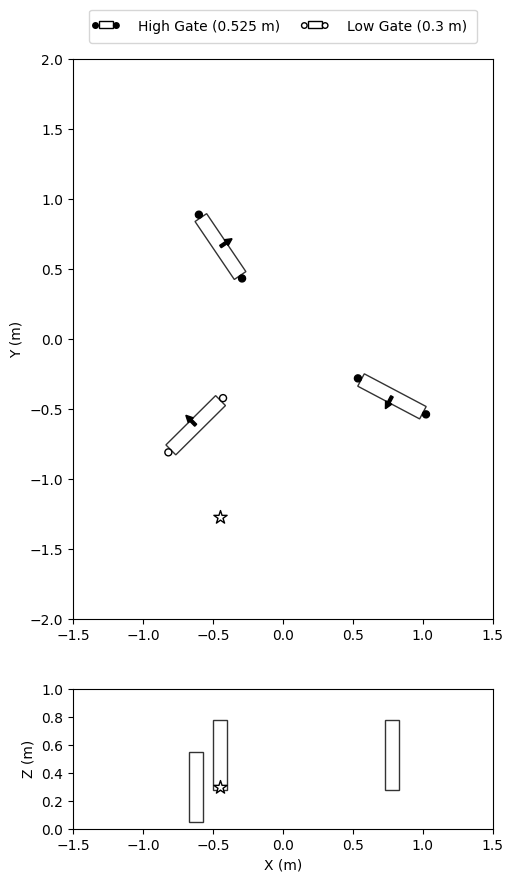

In [142]:
course = np.load(os.path.join(COURSE, "course.npy"))

_, axs = course_base_plot()
add_gates_to_course(course, axs, has_end=False)

In [123]:
B = 250
cudnn_benchmark(B, model, vae_downsample, "cuda")

[ planner ] Warming with cudnn benchmark...
[ planner ] Finished cudnn benchmark


[ 2835836756 ] Considered trajectories from 0


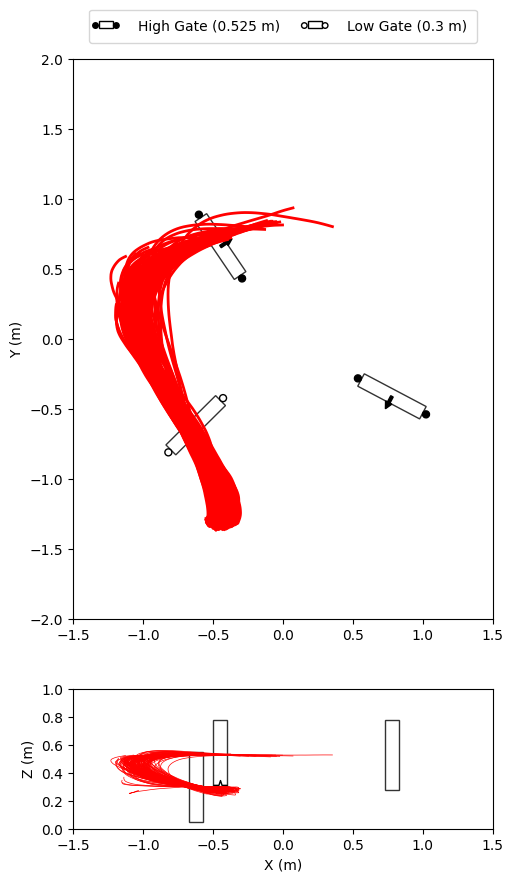

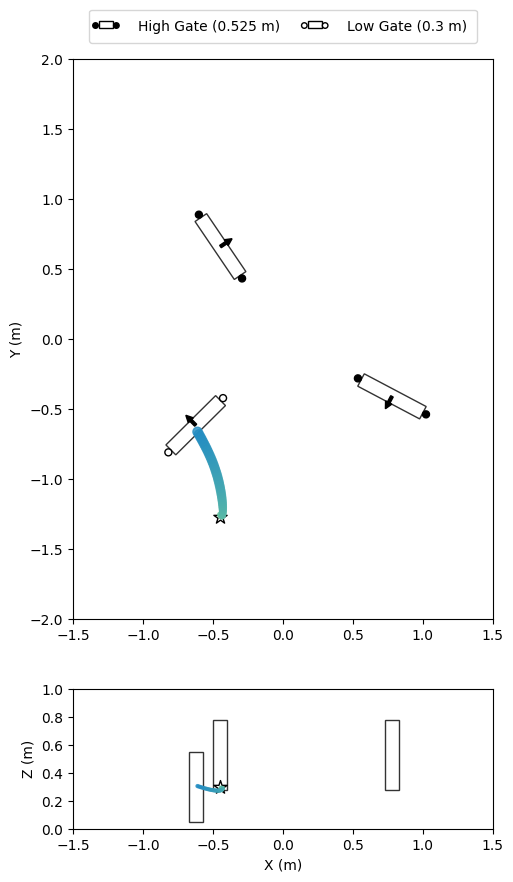

[ 2835836756 ] Considered trajectories from 1


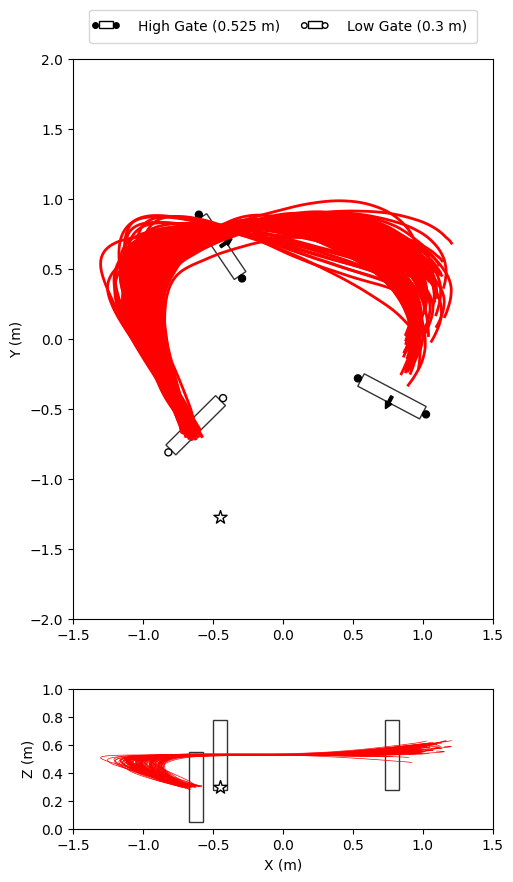

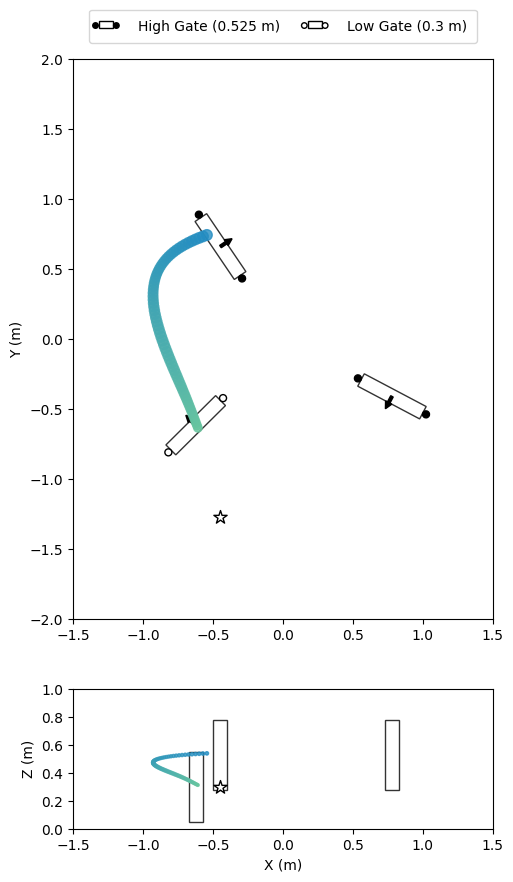

[ 2835836756 ] Considered trajectories from 2


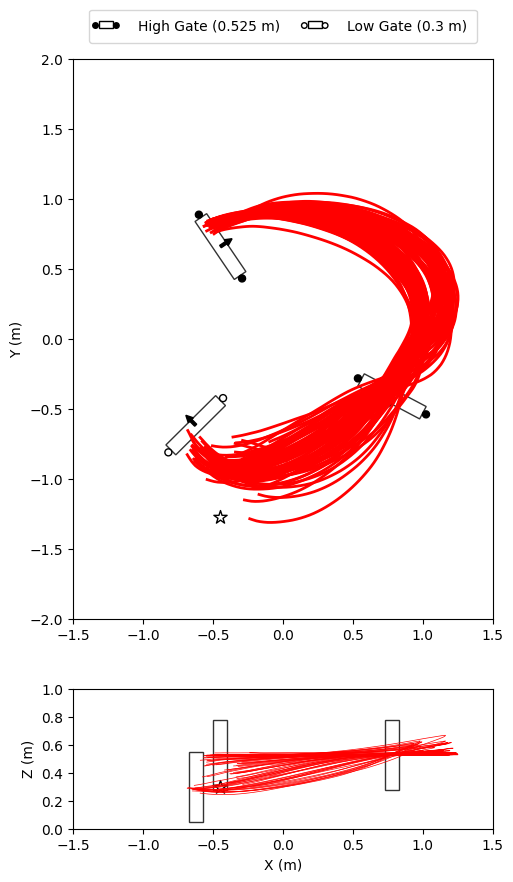

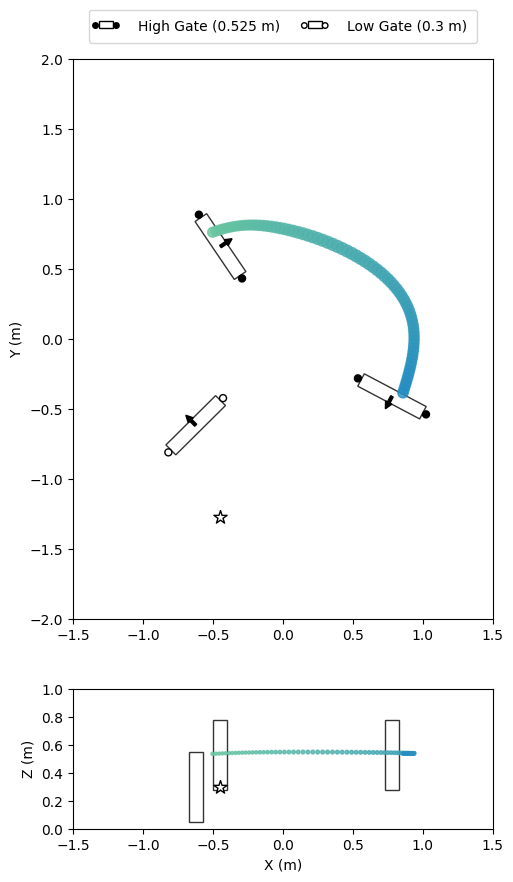

[ 2835836756 ] Considered trajectories from 3


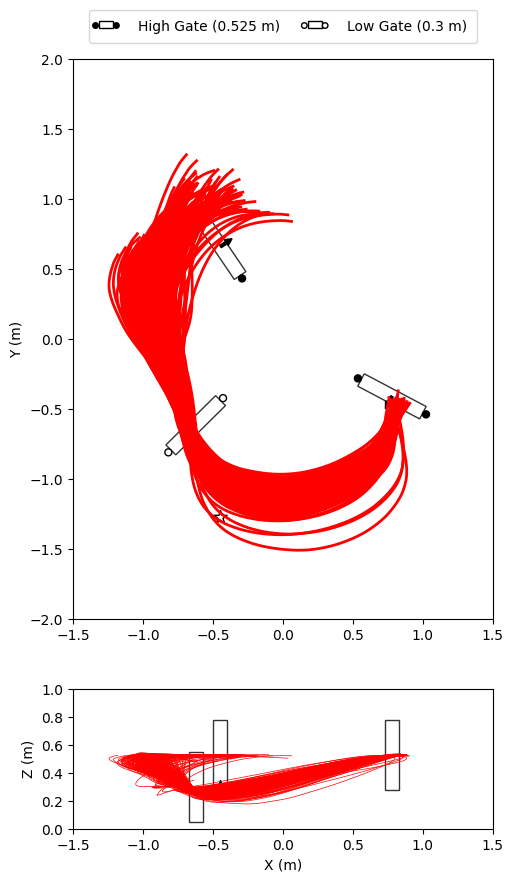

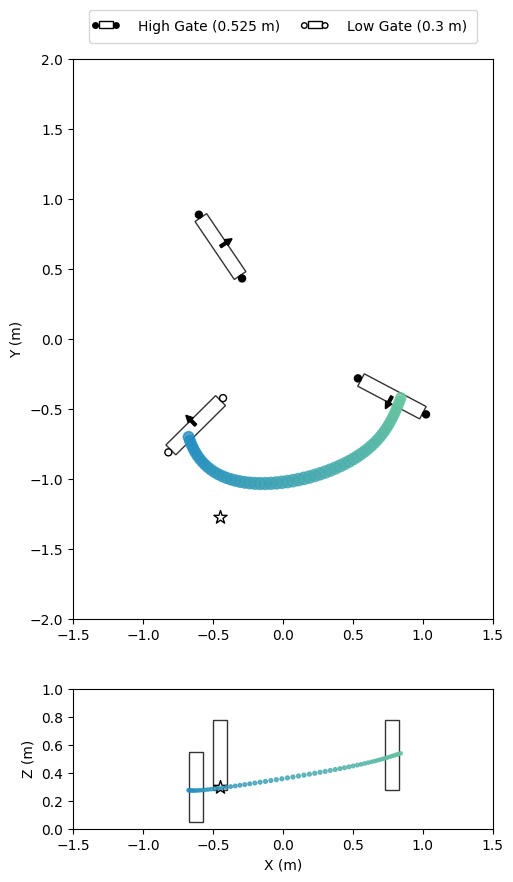

[ 2835836756 ] Considered trajectories from 1


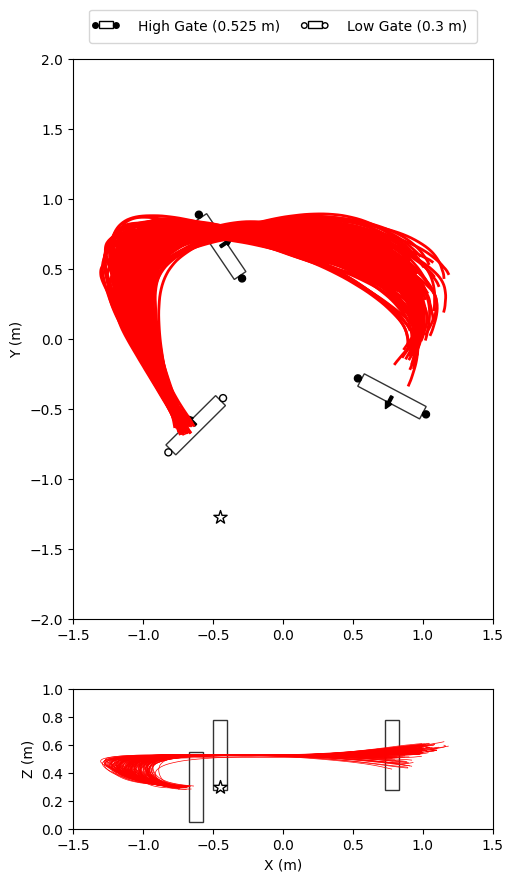

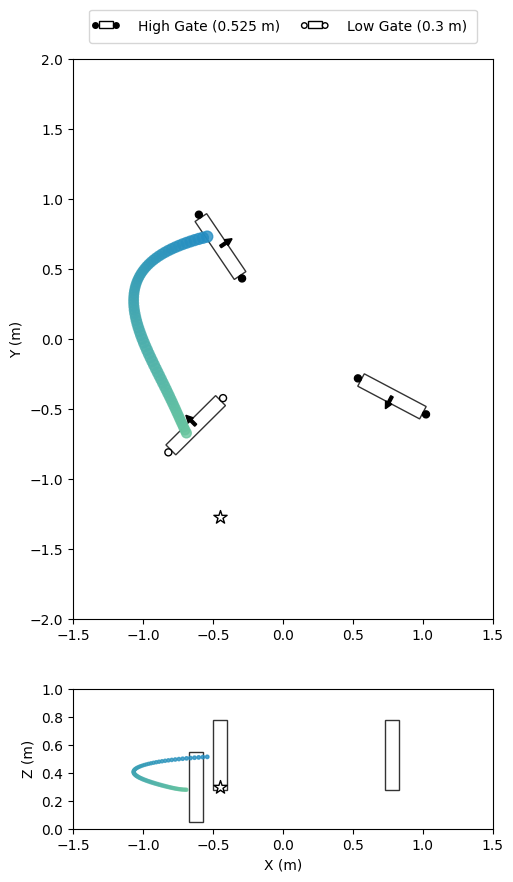

In [149]:
current_traj = None

gate_idx = 0

computation_times = []
trajectory_times = []
trajectories = []

for i in range(5):
    
    global_context = course
    if current_traj is not None:
        global_context = np.vstack((course[gate_idx + 1:], course[1:gate_idx]))    
    
    s = time.time()
    next_traj, candidates = plan(
        B,
        global_context,
        SamplerType.DDPM,
        ScoringMethod.FAST,
        model,
        vae_downsample,
        "cuda",
        current_traj=current_traj
    )
    trajectories.append(next_traj)
    
    computation_times.append(
        time.time() - s
    )
    trajectory_times.append(
        next_traj[0].shape[0] / 30
    )
    
    print(f"Considered trajectories from {gate_idx}")
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    for traj in candidates:
        add_trajectory_to_course(axs, traj.cpu().numpy(), reference=True)
    plt.show()
    plt.close()
    
    _, axs = course_base_plot()
    add_gates_to_course(course, axs, has_end=False)
    add_trajectory_to_course(axs, next_traj[0])
    plt.show()
    plt.close()
    
    gate_idx += 1
    current_traj = next_traj
    
    # Looped back around to previous gate
    if gate_idx == len(course):
        gate_idx = 1
    

In [148]:
print(sum(trajectory_times))

[ 2770381850 ] 10.8


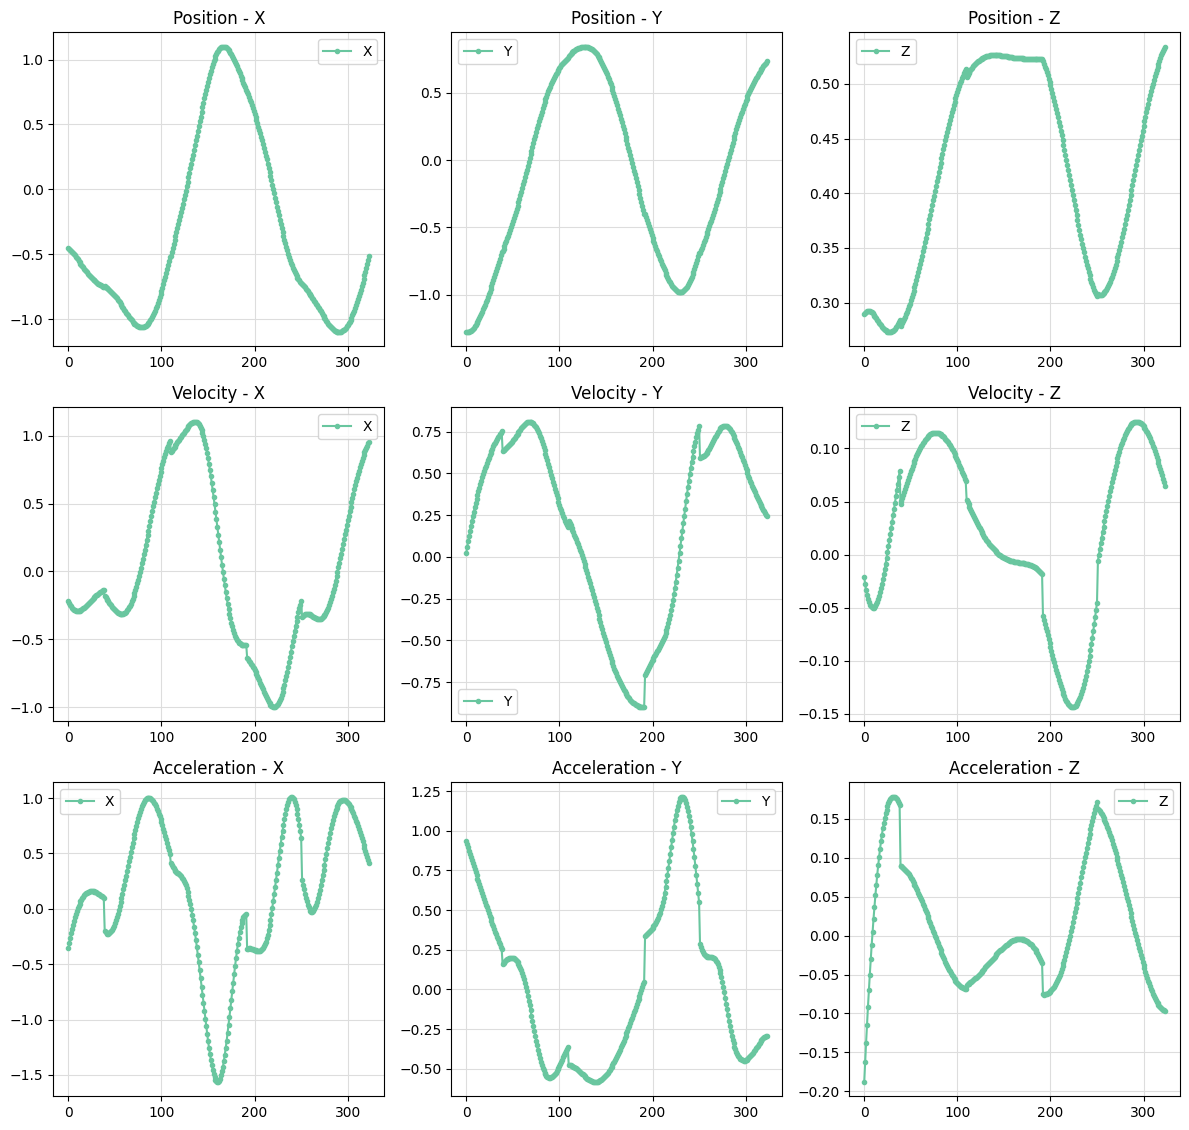

In [147]:
states = [np.vstack([t[idx] for t in trajectories]) for idx in range(3)]
plot_states(*states)

In [ ]:
# l0 = trajectories[12]

# _, axs = course_base_plot()
# add_gates_to_course(course, axs, has_end=False)

# epsilon = torch.randn_like(torch.tensor(l0))
# for i in [99]:
#     alpha_t = model.diffusion.alpha_bar[i].cpu()
#     l_t = torch.sqrt(alpha_t) * torch.tensor(l0) + torch.sqrt(1 - alpha_t) * epsilon
#     t = model.decoder(l_t.unsqueeze(0).cuda()).squeeze(0).cpu().numpy()
#     add_trajectory_to_course(axs, t, reference=False)

# # import matplotlib

# # colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color'][:3]
# # colors = [colors[2], colors[0], colors[1]]
# # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("primary", colors)
# # norm = matplotlib.colors.Normalize(vmin=-2, vmax=2.5)
# # plt.imshow(l0, cmap=cmap, norm=norm)
# # plt.show()